<a href="https://colab.research.google.com/github/claire-fang/cs182-final-project/blob/main/mod_subtraction/GPT2_subtraction_toy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Mount your Google Drive

import os
from google.colab import drive
drive.mount('/content/gdrive')

DRIVE_PATH = '/content/gdrive/MyDrive/gpt2_toy'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

%cd $DRIVE_PATH

Mounted at /content/gdrive
/content/gdrive/MyDrive/gpt2_toy


# GPT-2 Mod Subtraction Fine-tuning
This notebook fine-tunes GPT-2 on a custom mod-sub dataset, masks the prompt tokens in loss so the model only learns to predict the output list, and supports inference.

In [ ]:
import os
import random
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from transformers import (
    GPT2Tokenizer,
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments
)

In [ ]:
class ModSubDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_length=128):
        with open(file_path, 'r') as f:
            text = f.read().strip()
        self.examples = text.split('\n\n')
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        raw = self.examples[idx]
        prompt, answer = raw.split('\n', 1)
        eos = self.tokenizer.eos_token

        # Inject EOS between prompt and answer, and at the end
        full = prompt + eos + answer + eos
        tok = self.tokenizer(
            full,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': tok['input_ids'].squeeze(0),
            'attention_mask': tok['attention_mask'].squeeze(0)
        }

In [ ]:
def modsub_collate(batch):
    # 1) pull out lists of individual tensors
    input_ids_list     = [item['input_ids']     for item in batch]
    attention_mask_list= [item['attention_mask'] for item in batch]

    # 2) pad up to the longest in this batch
    input_ids     = pad_sequence(input_ids_list,     batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask= pad_sequence(attention_mask_list,batch_first=True, padding_value=0)

    # 3) clone for labels
    labels = input_ids.clone()

    # 4) mask out the prompt (everything up to and including the first EOS)
    eos_id = tokenizer.eos_token_id
    for i, seq in enumerate(input_ids):
        eos_positions = (seq == eos_id).nonzero(as_tuple=True)[0]
        if len(eos_positions)>0:
            prompt_end = eos_positions[0].item() + 1
        else:
            prompt_end = 0
        labels[i, :prompt_end] = -100

    # 5) mask out any padding positions
    labels[attention_mask == 0] = -100

    return {
        'input_ids':      input_ids,
        'attention_mask': attention_mask,
        'labels':         labels
    }

In [ ]:
def generate_modular_subtraction_examples(num_examples=3000, mod=97, seed=123):
    random.seed(seed)
    examples = []
    for _ in range(num_examples):
        a = random.randint(0, 100)
        b = random.randint(0, 100)
        result = (a - b) % mod
        examples.append(f"Input: {a} - {b} mod {mod}\nOutput: {result}")
    return examples

with open("mod_sub_train.txt", "w") as f:
    f.write("\n\n".join(generate_modular_subtraction_examples(seed=123)))

# with open("mod_sub_val.txt", "w") as f:
#     f.write("\n\n".join(generate_modular_subtraction_examples(num_examples=2000, seed=124)))


In [ ]:
def train(train_file, model_name='gpt2', output_dir='/content/gdrive/MyDrive/Outputs/gpt2_output',
          batch_size=32, epochs=50, max_length=128, save_steps=500):
    os.makedirs(output_dir, exist_ok=True)

    # Tokenizer
    global tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    # Save tokenizer for inference BEFORE training
    tokenizer.save_pretrained(output_dir)
    # dataset
    ds = ModSubDataset(train_file, tokenizer, max_length)
    # model
    model = GPT2LMHeadModel.from_pretrained(model_name)
    model.config.eos_token_id = tokenizer.eos_token_id
    model.config.pad_token_id = tokenizer.pad_token_id
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # training args
    args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        per_device_train_batch_size=batch_size,
        num_train_epochs=epochs,
        save_steps=save_steps,
        logging_steps=100,
        report_to='none'
    )
    # trainer
    trainer = Trainer(
        model=model,
        args=args,
        data_collator=modsub_collate,
        train_dataset=ds
    )
    trainer.train()
    trainer.save_model()


## Run Training

In [ ]:
train('/content/gdrive/MyDrive/Datasets/sort_sub_train_2.txt')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,1.345500
200,1.002600
300,0.764900
400,0.680200
500,0.616300
600,0.586100
700,0.560700
800,0.526900
900,0.506400
1000,0.480000


## Run Inference

In [ ]:
def infer(input_sequence: str,
          model_dir: str = '/content/gdrive/MyDrive/Outputs/gpt2_output', # gpt2_output3 is the best result
          max_new_tokens: int = 20):
    # 1) Load tokenizer & model
    tokenizer = GPT2Tokenizer.from_pretrained(model_dir)
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token':'<|pad|>'})
    model = GPT2LMHeadModel.from_pretrained(model_dir)
    model.resize_token_embeddings(len(tokenizer))
    model.config.eos_token_id = tokenizer.eos_token_id
    model.config.pad_token_id = tokenizer.pad_token_id

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()

    # 2) Tokenize with attention mask
    enc = tokenizer(
        input_sequence,
        return_tensors='pt',
        padding=False,
        truncation=True,
        add_special_tokens=False
    )
    input_ids = enc['input_ids'].to(device)
    attention_mask = enc['attention_mask'].to(device)

    # 3) Generate *only* max_new_tokens
    outputs = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_new_tokens=max_new_tokens,
        do_sample=False,    # ← switch to greedy
        num_beams=1,        # ← no beam search, just greedy
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
    )

    # 4) Slice off the prompt tokens and decode only the new ones
    gen_tokens = outputs[0, input_ids.shape[-1]:]
    result = tokenizer.decode(gen_tokens, skip_special_tokens=True)
    result = result.lstrip()
    # print(result)
    return result



In [ ]:
print(infer("Input: 6 - 34 mod 97\nOutput:"))
print(infer("Input: 6 - 35 mod 97\nOutput:"))
print(infer("Input: 6 - 36 mod 97\nOutput:"))
print(infer("Input: 6 - 37 mod 97\nOutput:"))
print(infer("Input: 6 - 38 mod 97\nOutput:"))
print(infer("Input: 6 - 39 mod 97\nOutput:"))
print(infer("Input: 6 - 40 mod 97\nOutput:"))

73
68
67
66
63
64
65


In [ ]:
print(infer("Input: 101 - 34 mod 97\nOutput:"))
print(infer("Input: 102 - 34 mod 97\nOutput:"))
print(infer("Input: 103 - 34 mod 97\nOutput:"))
print(infer("Input: 104 - 34 mod 97\nOutput:"))
print(infer("Input: 105 - 34 mod 97\nOutput:"))

55
54
55
62
49


## Test Accuracy

In [ ]:
import random

num_correct = 0
num_total = 1000

for i in range(num_total):
    a = random.randint(0, 100)
    b = random.randint(0, 100)
    mod = 97

    prompt = f"Input: {a} - {b} mod {mod}\nOutput:"
    expected = (a - b) % mod

    predicted = infer(prompt, model_dir='/content/gdrive/MyDrive/Outputs/gpt2_output')

    # Try to extract an integer from model output
    try:
        predicted_int = int(predicted.strip().split()[0])
    except:
        predicted_int = None

    if predicted_int == expected:
        num_correct += 1

    # if i % 100 == 0:
        # print(f"Step {i}: Current Accuracy = {num_correct / (i + 1):.3f}")

print(f"Total tested: {num_total}")
print(f"Final Accuracy: {num_correct / num_total:.3f}")


Total tested: 1000
Final Accuracy: 0.602


Tolerent Test Accuracy

In [ ]:
for i in range(num_total):
    a = random.randint(0, 100)
    b = random.randint(0, 100)
    mod = 97

    prompt = f"Input: {a} - {b} mod {mod}\nOutput:"
    expected = (a - b) % mod

    predicted = infer(prompt, model_dir='/content/gdrive/MyDrive/Outputs/gpt2_output')

    # Try to extract an integer from model output
    try:
        predicted_int = int(predicted.strip().split()[0])
    except:
        predicted_int = None

    if abs(predicted_int - expected) <= 3:
        num_correct += 1

print(f"Total tested: {num_total}")
print(f"Final Tolerent Accuracy: {num_correct / num_total:.3f}")

Total tested: 100
Final Accuracy: 0.840


# Analysis

In [ ]:
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from transformers import GPT2Tokenizer, GPT2Model
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

## PCA

100%|██████████| 10201/10201 [01:42<00:00, 99.15it/s] 


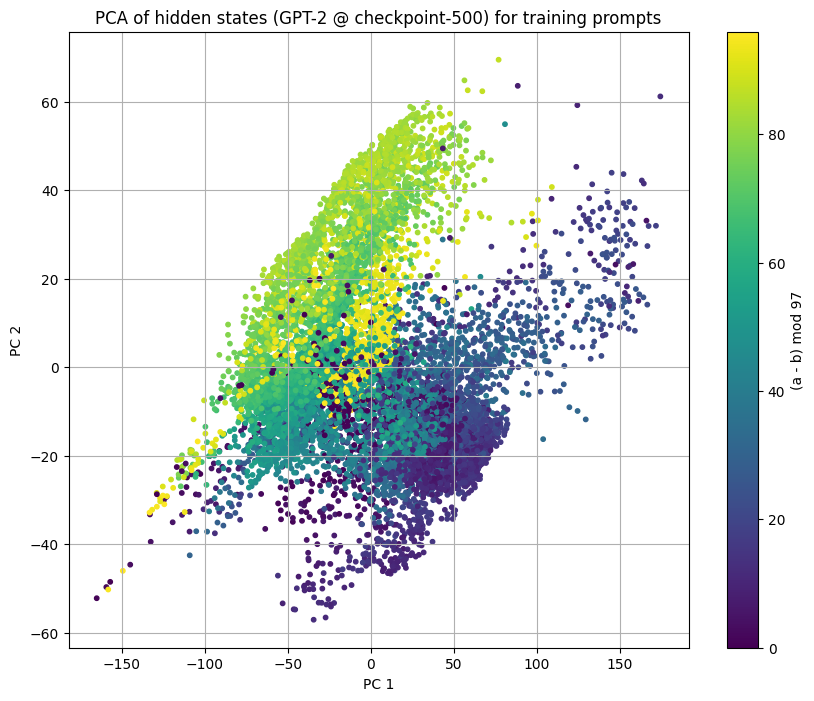

In [ ]:
model_path = "/content/gdrive/MyDrive/Outputs/gpt2_output/checkpoint-500"
tokenizer = GPT2Tokenizer.from_pretrained("/content/gdrive/MyDrive/Outputs/gpt2_output")
model = GPT2LMHeadModel.from_pretrained(model_path).cuda()
# model = GPT2LMHeadModel.from_pretrained(model_path).cpu()
model.eval()

p = 97
inputs = []
labels = []
for a in range(101):
    for b in range(101):
        prompt = f"Input: {a} - {b} mod {p}\nOutput:"
        inputs.append(prompt)
        labels.append((a, b, (a - b) % p))

# Extract the residual state of the last token
residuals = []
results = []

with torch.no_grad():
    for prompt, (a, b, result) in tqdm(zip(inputs, labels), total=len(inputs)):
        tokens = tokenizer(prompt, return_tensors='pt').to(model.device)
        outputs = model(**tokens, output_hidden_states=True)
        last_hidden = outputs.hidden_states[-1][0, -1, :].cpu().numpy()
        residuals.append(last_hidden)
        results.append(result)

# PCA
from sklearn.decomposition import PCA
residuals = torch.tensor(residuals)
projected = PCA(n_components=2).fit_transform(residuals)

# Visualize
plt.figure(figsize=(10, 8))
scatter = plt.scatter(projected[:, 0], projected[:, 1], c=results, cmap='viridis', s=10)
plt.colorbar(scatter, label="(a - b) mod 97")
plt.title("PCA of hidden states (GPT-2 @ checkpoint-500) for training prompts")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


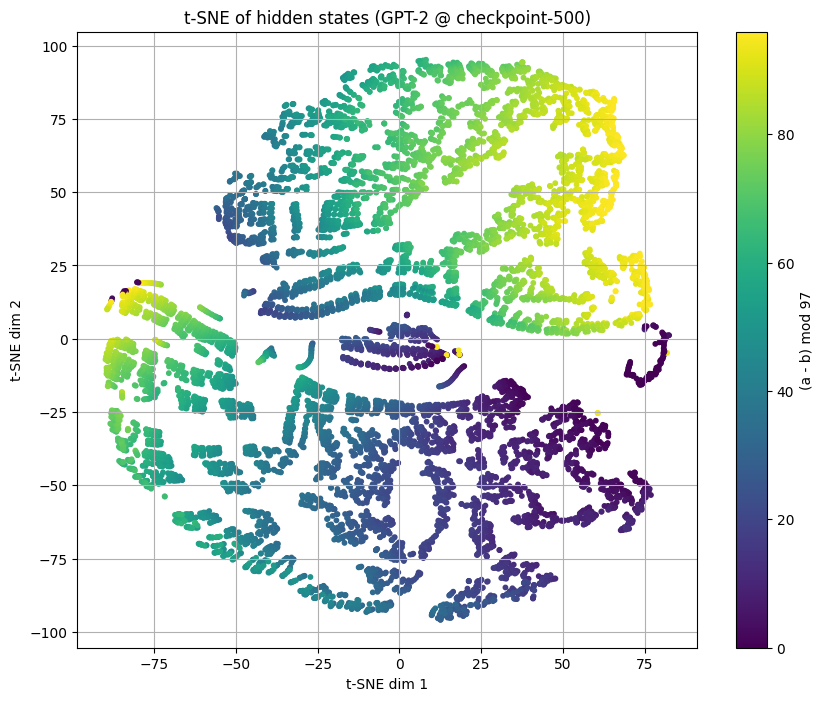

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
residuals_np = residuals.numpy()
residuals_np = StandardScaler().fit_transform(residuals_np)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
projected_tsne = tsne.fit_transform(residuals_np)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(projected_tsne[:, 0], projected_tsne[:, 1], c=results, cmap='viridis', s=10)
plt.colorbar(scatter, label="(a - b) mod 97")
plt.title("t-SNE of hidden states (GPT-2 @ checkpoint-500)")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.grid(True)
plt.show()

100%|██████████| 10201/10201 [01:43<00:00, 98.84it/s]


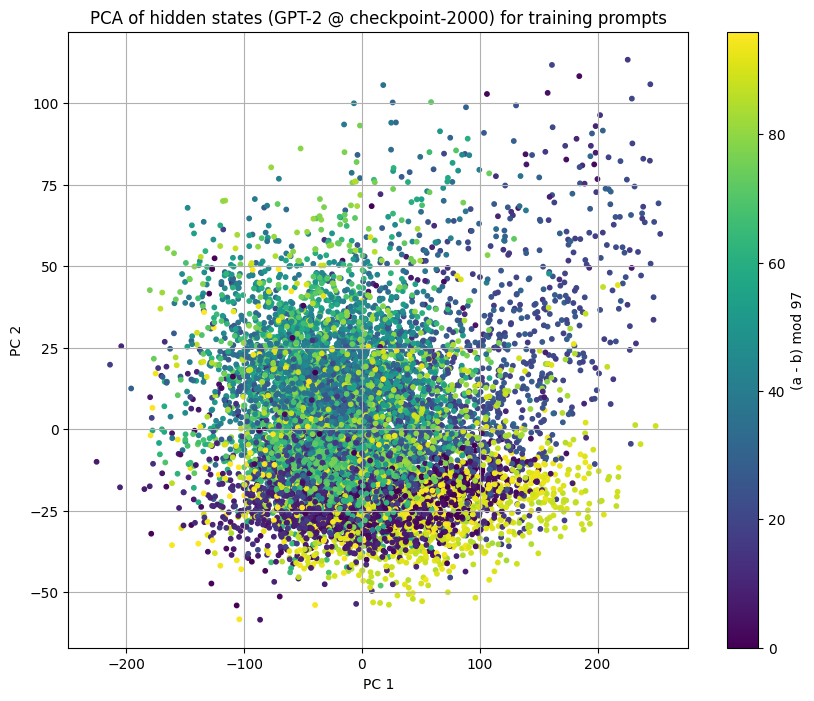

In [ ]:
model_path = "/content/gdrive/MyDrive/Outputs/gpt2_output/checkpoint-2000"
tokenizer = GPT2Tokenizer.from_pretrained("/content/gdrive/MyDrive/Outputs/gpt2_output")
model = GPT2LMHeadModel.from_pretrained(model_path).cuda()
# model = GPT2LMHeadModel.from_pretrained(model_path).cpu()
model.eval()

p = 97
inputs = []
labels = []
for a in range(101):
    for b in range(101):
        prompt = f"Input: {a} - {b} mod {p}\nOutput:"
        inputs.append(prompt)
        labels.append((a, b, (a - b) % p))

# Extract the residual state of the last token
residuals = []
results = []

with torch.no_grad():
    for prompt, (a, b, result) in tqdm(zip(inputs, labels), total=len(inputs)):
        tokens = tokenizer(prompt, return_tensors='pt').to(model.device)
        outputs = model(**tokens, output_hidden_states=True)
        last_hidden = outputs.hidden_states[-1][0, -1, :].cpu().numpy()
        residuals.append(last_hidden)
        results.append(result)

# PCA
from sklearn.decomposition import PCA
residuals = torch.tensor(residuals)
projected = PCA(n_components=2).fit_transform(residuals)

# Visualize
plt.figure(figsize=(10, 8))
scatter = plt.scatter(projected[:, 0], projected[:, 1], c=results, cmap='viridis', s=10)
plt.colorbar(scatter, label="(a - b) mod 97")
plt.title("PCA of hidden states (GPT-2 @ checkpoint-2000) for training prompts")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


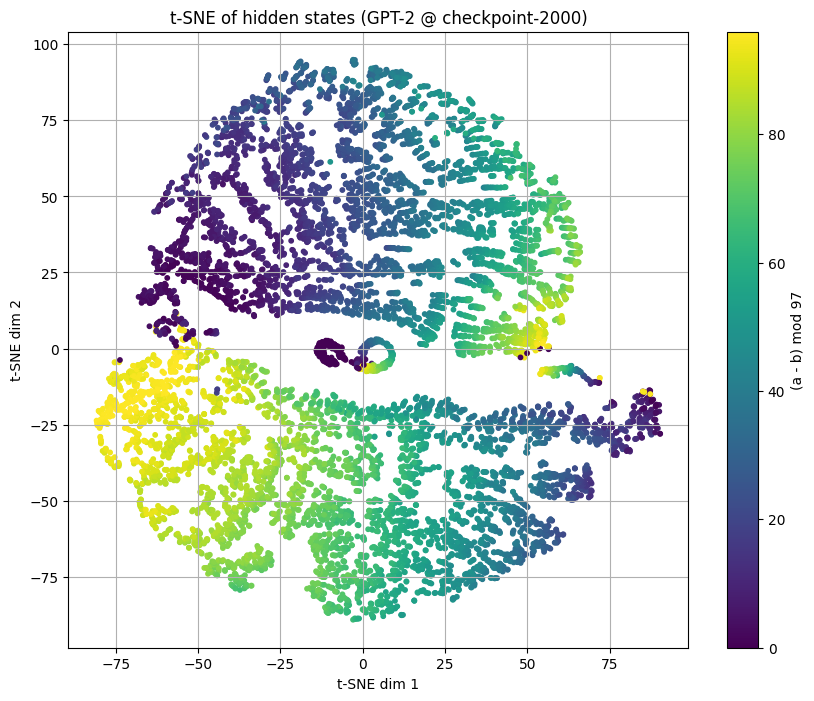

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
residuals_np = residuals.numpy()
residuals_np = StandardScaler().fit_transform(residuals_np)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
projected_tsne = tsne.fit_transform(residuals_np)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(projected_tsne[:, 0], projected_tsne[:, 1], c=results, cmap='viridis', s=10)
plt.colorbar(scatter, label="(a - b) mod 97")
plt.title("t-SNE of hidden states (GPT-2 @ checkpoint-2000)")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.grid(True)
plt.show()

100%|██████████| 10201/10201 [01:42<00:00, 99.26it/s]


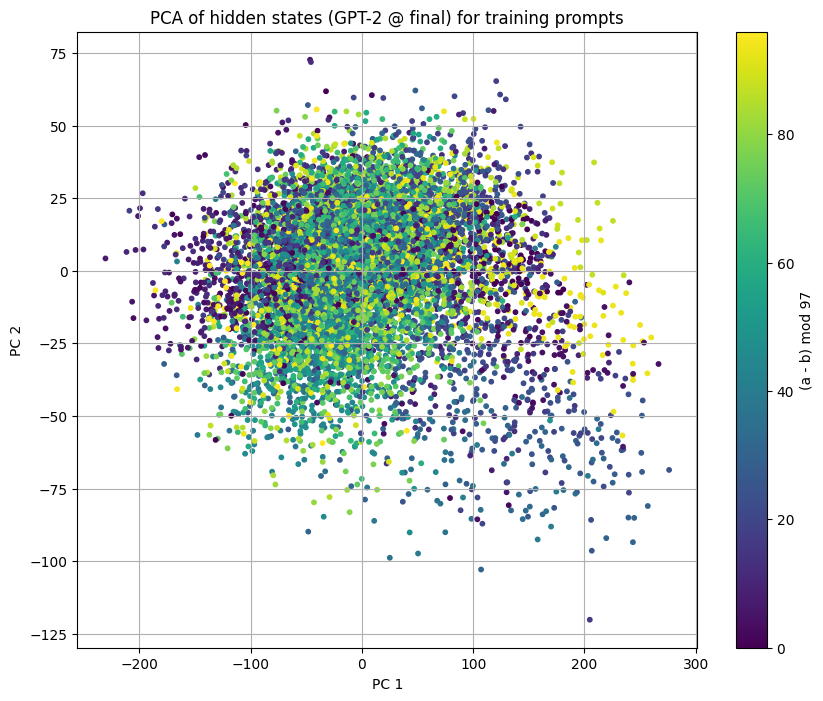

In [ ]:
model_path = "/content/gdrive/MyDrive/Outputs/gpt2_output"
tokenizer = GPT2Tokenizer.from_pretrained("/content/gdrive/MyDrive/Outputs/gpt2_output")
model = GPT2LMHeadModel.from_pretrained(model_path).cuda()
# model = GPT2LMHeadModel.from_pretrained(model_path).cpu()
model.eval()

p = 97
inputs = []
labels = []
for a in range(101):
    for b in range(101):
        prompt = f"Input: {a} - {b} mod {p}\nOutput:"
        inputs.append(prompt)
        labels.append((a, b, (a - b) % p))

# Extract the residual state of the last token
residuals = []
results = []

with torch.no_grad():
    for prompt, (a, b, result) in tqdm(zip(inputs, labels), total=len(inputs)):
        tokens = tokenizer(prompt, return_tensors='pt').to(model.device)
        outputs = model(**tokens, output_hidden_states=True)
        last_hidden = outputs.hidden_states[-1][0, -1, :].cpu().numpy()
        residuals.append(last_hidden)
        results.append(result)

# PCA
from sklearn.decomposition import PCA
residuals = torch.tensor(residuals)
projected = PCA(n_components=2).fit_transform(residuals)

# Visualize
plt.figure(figsize=(10, 8))
scatter = plt.scatter(projected[:, 0], projected[:, 1], c=results, cmap='viridis', s=10)
plt.colorbar(scatter, label="(a - b) mod 97")
plt.title("PCA of hidden states (GPT-2 @ final) for training prompts")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


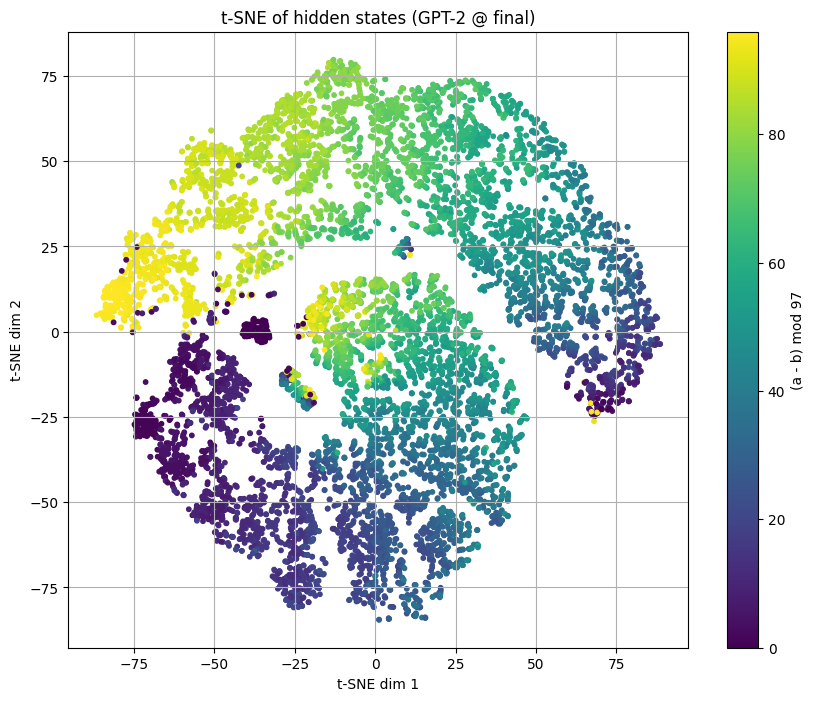

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 建议先标准化数据
from sklearn.preprocessing import StandardScaler
residuals_np = residuals.numpy()
residuals_np = StandardScaler().fit_transform(residuals_np)

# 进行 t-SNE 降维（建议 perplexity 不宜太大）
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
projected_tsne = tsne.fit_transform(residuals_np)

# 可视化
plt.figure(figsize=(10, 8))
scatter = plt.scatter(projected_tsne[:, 0], projected_tsne[:, 1], c=results, cmap='viridis', s=10)
plt.colorbar(scatter, label="(a - b) mod 97")
plt.title("t-SNE of hidden states (GPT-2 @ final)")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.grid(True)
plt.show()

## Linear Probing

In [ ]:
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from transformers import GPT2Tokenizer, GPT2Model
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm

model_path = '/content/gdrive/MyDrive/Outputs/gpt2_output'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2Model.from_pretrained(model_path, output_hidden_states=True).to(device)
model.eval()

In [ ]:
def probe_all_layers(model, tokenizer, prompts, targets, max_length=64):
    accuracies = []
    model.eval()
    with torch.no_grad():
        for layer in range(13):  # embeddings + 12 transformer layers
            features = []
            for p in prompts:
                tokens = tokenizer(p, return_tensors="pt", truncation=True, max_length=max_length).to(device)
                outputs = model(**tokens)
                h = outputs.hidden_states[layer][0, -1].cpu().numpy()  # last token
                features.append(h)
            clf = LogisticRegression(max_iter=1000).fit(features, targets)
            acc = clf.score(features, targets)
            print(f"Layer {layer:2d} probe accuracy: {acc:.4f}")
            accuracies.append(acc)
    return accuracies

num_samples = 500
a_vals = np.random.randint(0, 100, num_samples)
b_vals = np.random.randint(0, 100, num_samples)
prompts = [f"Input: {a} - {b} mod 97\nOutput:" for a, b in zip(a_vals, b_vals)]
labels = [(a - b) % 97 for a, b in zip(a_vals, b_vals)]

all_accs = probe_all_layers(model, tokenizer, prompts, labels)

Layer  0 probe accuracy: 0.0200
Layer  1 probe accuracy: 0.1880
Layer  2 probe accuracy: 0.4260
Layer  3 probe accuracy: 0.9040
Layer  4 probe accuracy: 0.9780
Layer  5 probe accuracy: 0.9980
Layer  6 probe accuracy: 1.0000
Layer  7 probe accuracy: 1.0000
Layer  8 probe accuracy: 1.0000
Layer  9 probe accuracy: 1.0000
Layer 10 probe accuracy: 1.0000
Layer 11 probe accuracy: 1.0000
Layer 12 probe accuracy: 1.0000


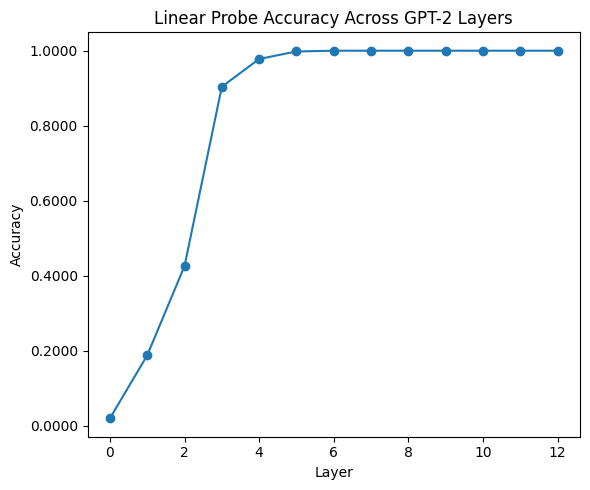

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(6, 5))
plt.plot(range(13), all_accs, marker='o', linestyle='-')
plt.title("Linear Probe Accuracy Across GPT-2 Layers")
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
plt.xticks(range(0, 13, 2))
plt.tight_layout()
plt.show()

# Logit Lens

In [ ]:
import torch
import numpy as np
from transformers import GPT2Tokenizer, GPT2LMHeadModel

model_path = '/content/gdrive/MyDrive/Outputs/gpt2_output3'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2LMHeadModel.from_pretrained(model_path, output_hidden_states=True).to(device)
model.eval()

allowed_tokens = [tokenizer.encode(str(i), add_special_tokens=False)[0] for i in range(97)]
newline_token = tokenizer.encode("\n", add_special_tokens=False)[0]
allowed_tokens.append(newline_token)

def top_digit_from_logits(logits):
    mask = torch.full_like(logits, -1e9)
    mask[:, allowed_tokens] = logits[:, allowed_tokens]
    top_id = int(torch.argmax(mask, dim=-1))
    return tokenizer.decode([top_id]).strip() if top_id != newline_token else "?"

def logit_lens(prompt, layer_to_show=range(12)):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        hidden_states = outputs.hidden_states  # tuple of hidden states per layer

    try:
        result = eval(prompt.split('Input:')[1].split('mod')[0]) % 97
    except:
        result = "?"

    print(f"Prompt: {prompt}", end=" ")
    print(infer(prompt))
    print(f"Expected: {result}\n")
    for layer in layer_to_show:
        h = hidden_states[layer][:, -1, :]
        logits = model.lm_head(h)
        pred = top_digit_from_logits(logits)
        tag  = "✅" if pred.isdigit() and int(pred) == result else "❌"
        print(f"Layer {layer:2d}: {pred:>3} {tag}")

# Example
a, b = 88, 34
prompt = f"Input: {a} - {b} mod 97\nOutput:"
logit_lens(prompt)

Prompt: Input: 88 - 34 mod 97
Output: 54
Expected: 54

Layer  0:   ? ❌
Layer  1:   ? ❌
Layer  2:   ? ❌
Layer  3:   ? ❌
Layer  4:   ? ❌
Layer  5:   ? ❌
Layer  6:   ? ❌
Layer  7:   ? ❌
Layer  8:   ? ❌
Layer  9:  44 ❌
Layer 10:  44 ❌
Layer 11:  54 ✅


In [ ]:
# ─────────────  Layer‑12 Logit‑Lens Accuracy  ─────────────
# Allowed tokens are digits 0‑96 + newline token
allowed_tokens = [tokenizer.encode(str(i), add_special_tokens=False)[0] for i in range(97)]
newline_tok = tokenizer.encode("\n", add_special_tokens=False)[0]
allowed_tokens.append(newline_tok)

def top_digit_from_logits(logits):
    """Return the top token restricted to digits 0‑96 (+ newline)."""
    mask = torch.full_like(logits, -1e9)
    mask[:, allowed_tokens] = logits[:, allowed_tokens]
    top_id = int(torch.argmax(mask, dim=-1))
    return tokenizer.decode([top_id]).strip() if top_id != newline_tok else "?"

def layer12_accuracy(num_samples=500):
    correct = 0
    for _ in range(num_samples):
        a, b = random.randint(0, 96), random.randint(0, 96)
        prompt = f"Input: {a} - {b} mod 97\nOutput:"
        expected = (a - b) % 97

        with torch.no_grad():
            inputs = tokenizer(prompt, return_tensors="pt").to(device)
            # Get the hidden states from layer 12 (last token's state)
            h12 = model(**inputs, output_hidden_states=True).hidden_states[12][0, -1]  # Layer 12, last token
            pred_tok = top_digit_from_logits(model.lm_head(h12.unsqueeze(0)))  # Apply lm_head for logits prediction

        if pred_tok.isdigit() and int(pred_tok) == expected:
            correct += 1

    return correct / num_samples

# Evaluate on 500 random (a,b) pairs
acc = layer12_accuracy(500)
print(f"Layer12 logit‑lens accuracy: {acc:.3f}")

Layer12 logit‑lens accuracy: 0.506


# Fourier Analysis

Final model top-5 FFT energy ratio (layer 10): 0.0165


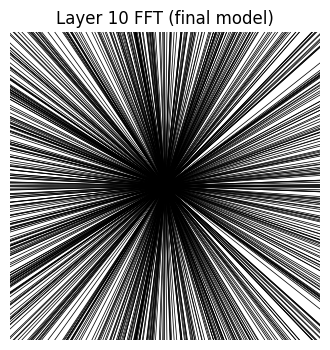

In [ ]:
# 8) Fourier analysis on the trained model

model_path = '/content/gdrive/MyDrive/Outputs/gpt2_output'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2LMHeadModel.from_pretrained(model_path, output_hidden_states=True).to(device)
model.eval()

def get_final_vec(model, tokenizer, prompt, layer=10):
    """
    Given a prompt and a model, returns the hidden state of the final token
    at the specified layer.
    """
    tok = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**tok, output_hidden_states=True)
        h = outputs.hidden_states[layer]  # [batch, seq_len, hidden_dim]
    return h[0, -1].cpu()  # 最后一个 token 的表示

def fft_energy_ratio(vec, k=5):
    """
    Compute the ratio of the sum of top-k FFT magnitudes to the total magnitude.
    A measure of how much energy is concentrated in the top frequencies.
    """
    coeff = torch.fft.fft(vec.double())
    mag = torch.abs(coeff)
    return (mag.topk(k).values.sum() / mag.sum()).item()

def quiver_plot(vec, title):
    """
    Plot the complex FFT coefficients as arrows (quiver plot).
    """
    coeff = torch.fft.fft(vec.double()).cpu().numpy()
    plt.figure(figsize=(4, 4))
    plt.quiver(
        np.zeros_like(coeff.real),
        np.zeros_like(coeff.imag),
        coeff.real,
        coeff.imag,
        angles='xy', scale_units='xy', scale=1
    )
    plt.title(title)
    plt.axis('off')
    plt.show()

# Example prompt (you can change the numbers here)
prompt = "Input: 7 - 4 mod 97\nOutput:"

# 8a) Extract the hidden vector from layer 10
vec_final = get_final_vec(model, prompt, layer=10)

# 8b) Compute and print the top-5 FFT energy ratio
energy_ratio_final = fft_energy_ratio(vec_final, k=5)
print(f"Final model top-5 FFT energy ratio (layer 10): {energy_ratio_final:.4f}")

# 8c) Visualize the FFT coefficients as a quiver plot
quiver_plot(vec_final, "Layer 10 FFT (final model)")

In [ ]:
# Compare early vs final FFT energy ratios to check for “grokking”–style emergence

early_ckpt = "/content/gdrive/MyDrive/Outputs/gpt2_output/checkpoint-3000"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = GPT2Tokenizer.from_pretrained('/content/gdrive/MyDrive/Outputs/gpt2_output')
early_model = GPT2LMHeadModel.from_pretrained(early_ckpt, local_files_only=True, output_hidden_states=True).to(device)
early_model.eval()

prompt = "Input: 7 - 4 mod 97\nOutput:"

vec_early = get_final_vec(early_model, tokenizer, prompt, layer=10)
energy_ratio_early = fft_energy_ratio(vec_early, k=5)

vec_final = get_final_vec(model, tokenizer, prompt, layer=10)
energy_ratio_final = fft_energy_ratio(vec_final, k=5)

# Print both for comparison
print(f"Early checkpoint top-5 FFT energy ratio (layer 10): {energy_ratio_early:.4f}")
print(f"Final model top-5 FFT energy ratio (layer 10): {energy_ratio_final:.4f}")

Early checkpoint top-5 FFT energy ratio (layer 10): 0.0181
Final model top-5 FFT energy ratio (layer 10): 0.0165


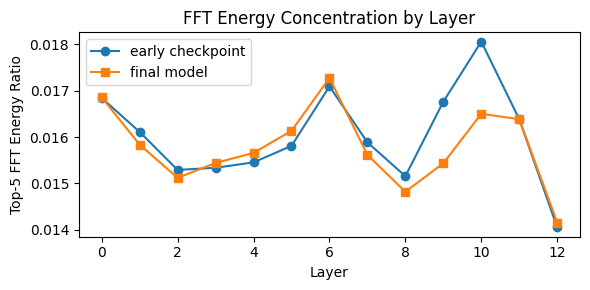

In [ ]:
# Compute top-5 FFT energy ratios for each layer (0–12)
# on both an early checkpoint and the final fine-tuned model.

early_ckpt = "/content/gdrive/MyDrive/Outputs/gpt2_output/checkpoint-3000"
final_ckpt = "/content/gdrive/MyDrive/Outputs/gpt2_output"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from transformers import GPT2Tokenizer, GPT2LMHeadModel
tokenizer = GPT2Tokenizer.from_pretrained(final_ckpt)

early_model = GPT2LMHeadModel.from_pretrained(early_ckpt, local_files_only=True, output_hidden_states=True).to(device)
final_model = GPT2LMHeadModel.from_pretrained(final_ckpt, output_hidden_states=True).to(device)

early_model.eval()
final_model.eval()

prompt = "Input: 7 - 4 mod 97\nOutput:"


def get_final_vec(model, tokenizer, prompt, layer=10):
    tokens = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**tokens, output_hidden_states=True)
    return outputs.hidden_states[layer][0, -1].cpu()  # 获取最后 token 的 hidden vector

def fft_energy_ratio(vec, k=5):
    coeff = torch.fft.fft(vec.double())
    mag = torch.abs(coeff)
    return (mag.topk(k).values.sum() / mag.sum()).item()

layers = list(range(13))  # embeddings + 12层 transformer
ratios_early = []
ratios_final = []

for L in layers:
    ve = get_final_vec(early_model, tokenizer, prompt, layer=L)
    vf = get_final_vec(final_model, tokenizer, prompt, layer=L)
    ratios_early.append(fft_energy_ratio(ve, k=5))
    ratios_final.append(fft_energy_ratio(vf, k=5))

plt.figure(figsize=(6, 3))
plt.plot(layers, ratios_early, marker='o', label='early checkpoint')
plt.plot(layers, ratios_final, marker='s', label='final model')
plt.xlabel('Layer')
plt.ylabel('Top-5 FFT Energy Ratio')
plt.title('FFT Energy Concentration by Layer')
plt.legend()
plt.tight_layout()

plt.savefig('fft_energy_ratio_by_layer.png', dpi=300)
plt.show()

In [ ]:
import nbformat

notebook_path = "early_ckpt = "/content/gdrive/MyDrive/GPT2_subtraction_toy.ipynb"  # 替换为你的 notebook 路径

# 读取 notebook
with open(notebook_path, "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=nbformat.NO_CONVERT)

# 检查并修复 metadata.widgets
if "widgets" in nb.metadata and "state" not in nb.metadata["widgets"]:
    print("Fixing missing 'state' in metadata.widgets...")
    nb.metadata["widgets"]["state"] = []

# 保存修复后的 notebook
with open(notebook_path, "w", encoding="utf-8") as f:
    nbformat.write(nb, f)

print("Notebook metadata fixed.")
